In [292]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch. optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
import pickle
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import random
import numpy as np
import imageio


In [3]:
resnet = models.resnet18(weights='DEFAULT')
resnet_half = torch.nn.Sequential(*(list(resnet.children())[:7]))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_size = 12544
        self.encoder = nn.Sequential(
            *(list(resnet_half.children())),
            nn.ReLU(),
            nn.Flatten()
        )
        self.mu = nn.Sequential(
            nn.Linear(12544, self.latent_size)
        )
        self.log_var = nn.Sequential(
            nn.Linear(12544, self.latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([256, 7, 7])),
            nn.ConvTranspose2d(256, 256, (3,3),(2,2), padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, (3,3),(2,2)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(2,2)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(2,2)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, (4,4),(1,1), padding=1),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        x = self.reparameterize(mu, log_var)
        x = self.decoder(x)
        return x, mu, log_var

In [5]:
file = open('C:/VSCode/VAE/Faces_VAE/checkpoint300.pickle', 'rb')
model = pickle.load(file)

In [63]:
file = open('C:/VSCode/VAE/Faces_VAE/Faces_VAE/model1.pkl', 'rb')
state_dict = torch.load(file)
model = Net()
model.load_state_dict(state_dict)

C:\Users\ericy\AppData\Local\Temp\ipykernel_2012\4037938058.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file)


<All keys matched successfully>

In [6]:
cuda = 'cuda:1'

In [7]:
class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.l = len(self.data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

In [8]:
file = open('C:/VSCode/VAE/Faces_VAE/train_dataset_small.pkl', 'rb')
train_dataset = pickle.load(file)
file.close()
file = open('C:/VSCode/VAE/Faces_VAE/test_dataset_small.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

In [9]:
train_batch_size = 400
test_batch_size = 200
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

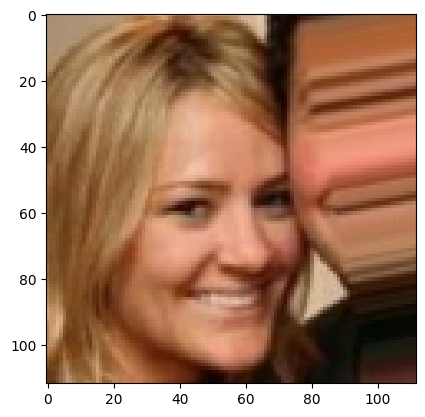

In [10]:
image = next(iter(train_loader))
plt.imshow(image[0].permute(1,2,0))
plt.show()

In [11]:
#model = nn.DataParallel(model, device_ids=[1,0])
model.to(cuda)

Net(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

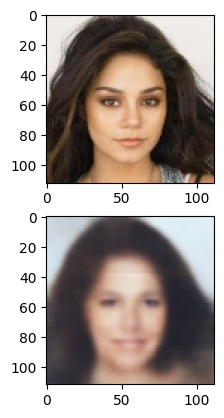

In [12]:
fig, ax = plt.subplots(2)
torch.no_grad()
x_train = next(iter(train_loader))
x_train = x_train.to(cuda)
outputs, mu, log_var = model(x_train)
outputs = outputs.cpu().detach()
ax[0].imshow(x_train.cpu()[0].permute((1,2,0)))
ax[1].imshow(outputs[0].permute(1,2,0)) 

In [14]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([256, 7, 7])),
            nn.ConvTranspose2d(256, 256, (3,3),(2,2), padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, (3,3),(2,2)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(2,2)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(2,2)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, (4,4),(1,1), padding=1),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.decoder(x)
        return x

In [79]:
from collections import OrderedDict

decoder_state_dict = OrderedDict()
decoder = Decoder()
decoder.eval()
for key in model.state_dict().keys():
    if key[0:7] == "decoder":
        decoder_state_dict[key] = model.state_dict()[key]

decoder.load_state_dict(decoder_state_dict)

<All keys matched successfully>

In [ ]:

input_size = 12544
input_seed = torch.randn(input_size)

#variation_dim = random.randint(0,input_size - 1)

In [242]:
input = torch.zeros(1000, input_size)
for i in range(1000):
    torch.zeros(1000)
    input[i] = input_seed + torch.tensor([(i-500)/50 for _ in range(input_size)])

In [ ]:
output = decoder(input).detach().numpy()
output = np.transpose(output, (0, 2, 3, 1))*255
output = output.astype(np.uint8)

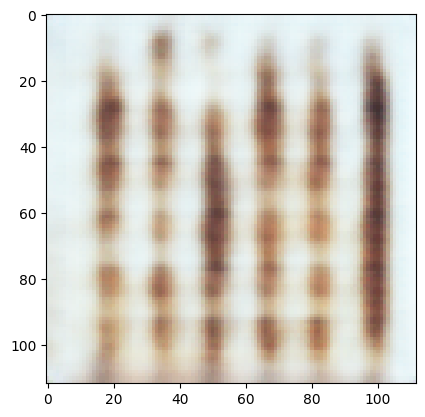

In [277]:
i = random.randint(0,999)
plt.imshow(output[i])

In [296]:
imageio.mimwrite("output.gif",  output, 'GIF', duration = 0.03)